In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# imports for DecisionTree graph visualization
from IPython.display import Image
from IPython.display import IFrame
import pydotplus
from sklearn import tree

import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, make_scorer, precision_score, roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import pickle
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick

np.random.seed(42)

# If PICKLE value is False, GridSeearchCV function won't be started and model will be taken from already saved models
# Have in mind that even that all models are saved with pickle if you run the whole project it will taka about 30 minutes
# to run because Learing curve and scores must be calculated using the given model !!!
PICKLE = False

# Predict Telco  Churn Customers 

## Hypertuning different models to find the best

### Abstract 
What I will do in this project is to predict if a give customer will churn or won't leave his operator. Some people will say "How will you do this? With a crystal ball?" My answer is: I have data, maths and my skills and I will show you how with given information for each customer and label for each customer that tells us if customer churn or not, I will make multiple models that will make predict if customer is loyal and happy with his operator or he will churn. I will evaluate each model and decide which is best in the end.

### 1. Data Preprocessing

Dataset is provided by IBM. Let's read it and start working on it.

In [5]:
customers_data = pd.read_csv("data/Telco-Customer-Churn.csv")

In [6]:
customers_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Our target variable are labeled Yes and No. It's better map them to numerical values 0  and 1.

In [7]:
customers_data.Churn = customers_data.Churn.map({"No": 0, "Yes": 1})

In [8]:
customers_data.shape

(7043, 21)

In [9]:
customers_data.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [10]:
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null int64
dtypes: float64(1), int64(3), obje

We have 7043 customers with 21 features for each of them. Let's see each feature meaning and it's values.

In [11]:
for col in customers_data.columns:
    print(f"Feature name: {col}, Values: {customers_data[col].unique()}")

Feature name: customerID, Values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Feature name: gender, Values: ['Female' 'Male']
Feature name: SeniorCitizen, Values: [0 1]
Feature name: Partner, Values: ['Yes' 'No']
Feature name: Dependents, Values: ['No' 'Yes']
Feature name: tenure, Values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Feature name: PhoneService, Values: ['No' 'Yes']
Feature name: MultipleLines, Values: ['No phone service' 'No' 'Yes']
Feature name: InternetService, Values: ['DSL' 'Fiber optic' 'No']
Feature name: OnlineSecurity, Values: ['No' 'Yes' 'No internet service']
Feature name: OnlineBackup, Values: ['Yes' 'No' 'No internet service']
Feature name: DeviceProtection, Values: ['No' 'Yes' 'No internet service']
Feature name: TechSupport, Values: ['No' '

CustomerID -  Customer ID number

SeniorCitizen - Binary variable. 1 is for a senior citizen and 0 for not a senior citizen

Parner - Variable show if this customer has partner or not

Dependants - Variable shows if customer has dependents or not

tenure - A numerical value between 1 - 72. This are the amount of months customer is with that operator

PhoneService - Value shows if customer has or not phone service

MultipleLines - Value shows if customer has multiple lines or not

InternetService - Value shows if customer uses DSL or fiber optic internet or doesn't use any fixed internet

OnlineSecurity - Value shows if customer uses online secirity

OnlineBackup - Value shows if customer has online backup service

DeviceProtection - Value shows if customer has device protection

TechSupport - Value shows if customer can use technical support from his operator

TechSupport - Value shows if customer can use streaming TV service

StreamingMovies - Value shows if customer can use streaming movies service

Contract - Value show what kind of contract customer has signed

PaperlessBilling - Value shows if customer has paper billing or not

PaymentMethod - Value shows how customer pays his bills to company

MonthlyCharges - Numeric value of amount charged to the customer monthly

TotalCharges - Numeric value of total amount charged to the customer

Churn - Value show is customer churned or not.

We are familiar with our data so these are the conclusions and actions we will take:

- We will remove customerID column because it consists of 7043 unique values.

In [12]:
customers_data = customers_data.drop("customerID", axis = 1)

- We will change "No internet service" to "No" for columns OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies and for column MultipleLines we will change "No phone service" to  "No", because that additional value doesn't give us more information.

In [13]:
replace_columns = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
for col in replace_columns:
    customers_data[col] = customers_data[col].replace({"No internet service": "No"})

In [14]:
customers_data["MultipleLines"] = customers_data["MultipleLines"].replace({"No phone service": "No"})

- TotalCharges column type is object, so we need to make it float. It looked like there are no missing values in our data, but when we tried to make all values in TotalCharges to be type "float" in turned out we can, because we have value with are not numerical. So let's check for values contanting only space.

In [15]:
customers_data["TotalCharges"].str.isspace().sum()

11

- Ok we have 11 rows with missing data so easiest way to fix it is to remove those rows. We can do this easily because that's 0.16% of all our data.

In [16]:
customers_data = customers_data.drop(index = customers_data[customers_data["TotalCharges"].str.isspace()].index, axis = 0)

In [17]:
customers_data["TotalCharges"] = customers_data["TotalCharges"].astype("float")

- We see that tenure value which is amount of month is from 1 to 72 is numeric variable. We can group those number is 6 categories. This is called feature engineering. This addition feature may help our model to produce better results. 

In [18]:
np.sort(customers_data.tenure.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72], dtype=int64)

In [19]:
def tenure_years(df) :

    for i in range(0, 73, 12):
        if (df["tenure"] > i) & (df["tenure"] <= i+12):
            return f"Months_{i}-{i+12}"
        
customers_data["tenure_months"] = customers_data.apply(lambda customers_data: tenure_years(customers_data), axis = 1)

In [20]:
customers_data.tenure_months.unique()

array(['Months_0-12', 'Months_24-36', 'Months_36-48', 'Months_12-24',
       'Months_60-72', 'Months_48-60'], dtype=object)

- SeniorCitizen column has numeric values when it's categorical feature so let's change values to Yes and No.

In [21]:
customers_data["SeniorCitizen"] = customers_data.SeniorCitizen.map({0: "No", 1: "Yes"})

This should be enough. Let's see the result.

In [22]:
customers_data.shape

(7032, 21)

In [23]:
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
gender              7032 non-null object
SeniorCitizen       7032 non-null object
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null int64
tenure_months       7032 non-null object
dtypes: float64(2), int64(2), ob

In [24]:
customers_data.groupby("Churn").size() / len(customers_data)

Churn
0    0.734215
1    0.265785
dtype: float64

We have 7032 observations to work with. Distribution is not perfect with 73.4% to 26.6% but it could have been worst. We will take this into account when we evaluate our models.

### 2. Exploratory data analysis

So far we got to know what each feature of our data means. Now let's find interconnection between those feature in order to be able to analyze and fine-tune are models later.

In [25]:
# Taking first 17 column names without tenure which are categorical variables
column_names = customers_data.iloc[:, 0:17].columns.drop("tenure")

In [26]:
column_names

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

Churn  gender
0      Female    2544
       Male      2619
1      Female     939
       Male       930
dtype: int64


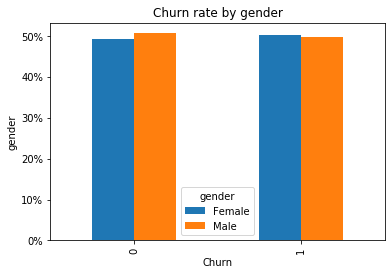

Churn  SeniorCitizen
0      No               4497
       Yes               666
1      No               1393
       Yes               476
dtype: int64


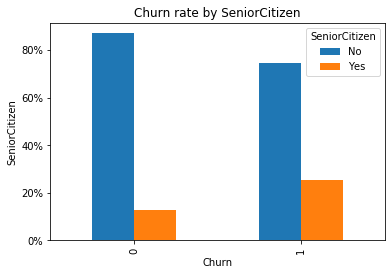

Churn  Partner
0      No         2439
       Yes        2724
1      No         1200
       Yes         669
dtype: int64


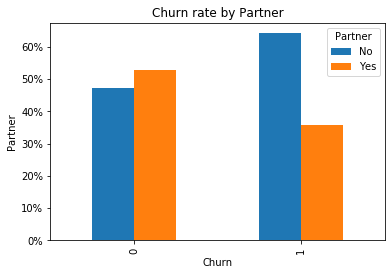

Churn  Dependents
0      No            3390
       Yes           1773
1      No            1543
       Yes            326
dtype: int64


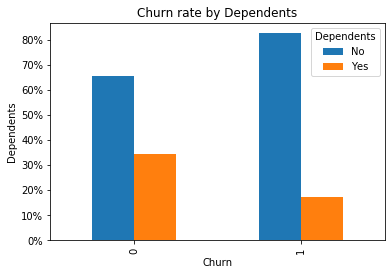

Churn  PhoneService
0      No               510
       Yes             4653
1      No               170
       Yes             1699
dtype: int64


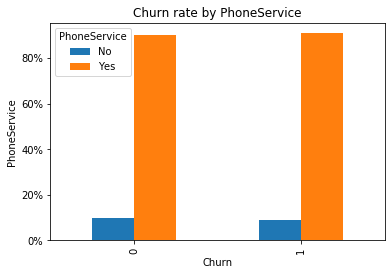

Churn  MultipleLines
0      No               3046
       Yes              2117
1      No               1019
       Yes               850
dtype: int64


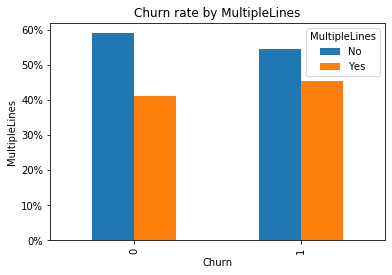

Churn  InternetService
0      DSL                1957
       Fiber optic        1799
       No                 1407
1      DSL                 459
       Fiber optic        1297
       No                  113
dtype: int64


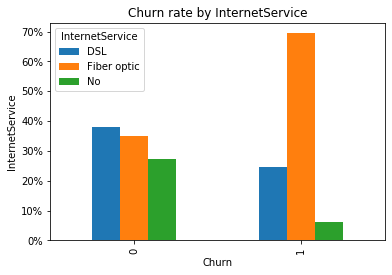

Churn  OnlineSecurity
0      No                3443
       Yes               1720
1      No                1574
       Yes                295
dtype: int64


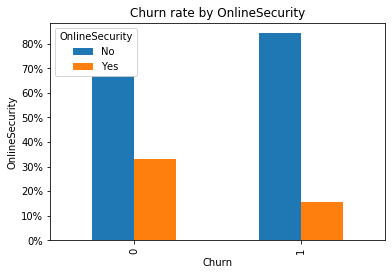

Churn  OnlineBackup
0      No              3261
       Yes             1902
1      No              1346
       Yes              523
dtype: int64


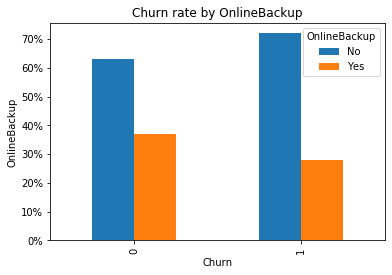

Churn  DeviceProtection
0      No                  3290
       Yes                 1873
1      No                  1324
       Yes                  545
dtype: int64


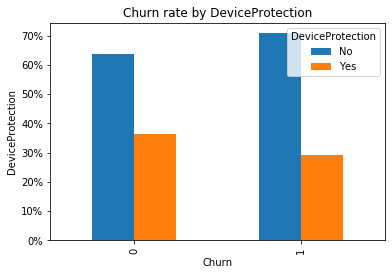

Churn  TechSupport
0      No             3433
       Yes            1730
1      No             1559
       Yes             310
dtype: int64


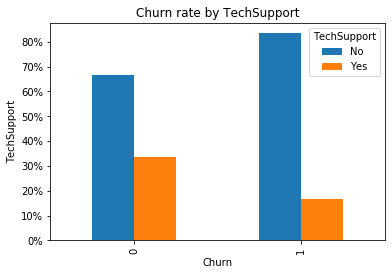

Churn  StreamingTV
0      No             3274
       Yes            1889
1      No             1055
       Yes             814
dtype: int64


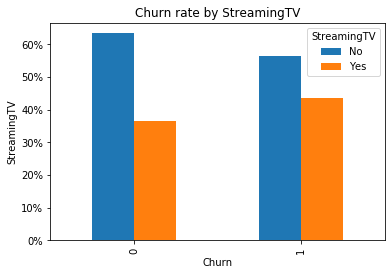

Churn  StreamingMovies
0      No                 3250
       Yes                1913
1      No                 1051
       Yes                 818
dtype: int64


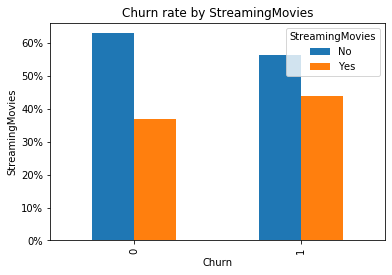

Churn  Contract      
0      Month-to-month    2220
       One year          1306
       Two year          1637
1      Month-to-month    1655
       One year           166
       Two year            48
dtype: int64


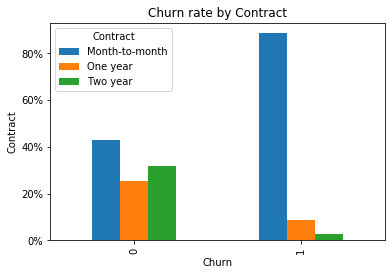

Churn  PaperlessBilling
0      No                  2395
       Yes                 2768
1      No                   469
       Yes                 1400
dtype: int64


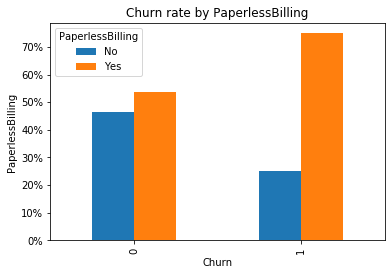

Churn  PaymentMethod            
0      Bank transfer (automatic)    1284
       Credit card (automatic)      1289
       Electronic check             1294
       Mailed check                 1296
1      Bank transfer (automatic)     258
       Credit card (automatic)       232
       Electronic check             1071
       Mailed check                  308
dtype: int64


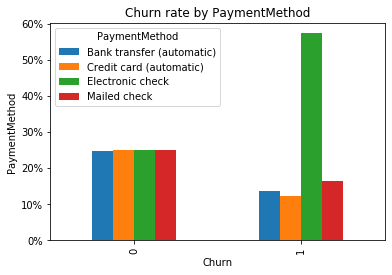

In [27]:
for attribute in column_names:
    print(customers_data.groupby(['Churn',attribute]).size())
    customers_data.groupby(['Churn',attribute]).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
    ).unstack().plot(kind='bar',stacked=False)
    
    plt.ylabel(attribute)
    plt.title(f"Churn rate by {attribute}")
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.show()


- There is no significant difference in churn rate by gender
- Most customers are not senior and senior customers are less likely to Churn
- Most of customers have phone service
- From the customer who churn 2/3 don't have partner whereas from loyal customer more have partner
- Not churn customers have fairly equal distribution for Internet service whereas most of churn customer use fiber optic Internet. This may imply that company fiber optic Internet may be slow or unreliable but we can't be sure
- Most customers doesn't have online security
- When we look and 3 types of contracts we see that more than 80 % of churn customer have month-to-month contact. 
- 60% of people who churn pay their bill by electronic check. There isn't significant difference in payment method for not churn customers. 

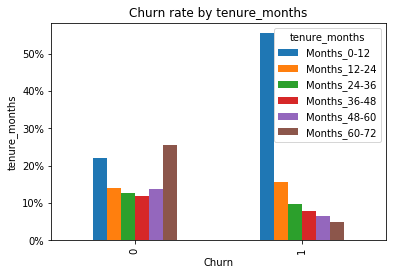

In [28]:
customers_data.groupby(['Churn',"tenure_months"]).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()
    ).unstack().plot(kind='bar',stacked=False)
    
plt.ylabel("tenure_months")
plt.title(f"Churn rate by tenure_months")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

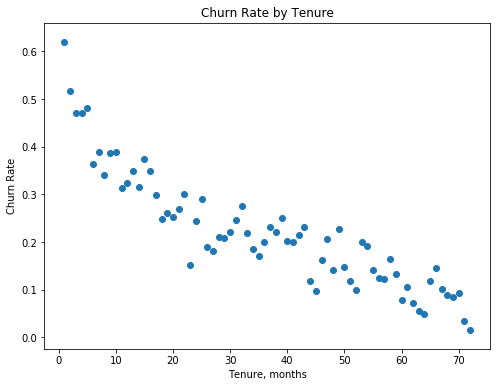

In [29]:
churn_monthlycharges = customers_data.groupby(by = 'tenure')['Churn'].mean().reset_index()
churn_monthlycharges

plt.figure(figsize=(8,6))
plt.scatter(churn_monthlycharges.tenure, churn_monthlycharges.Churn)
plt.title('Churn Rate by Tenure')
plt.xlabel('Tenure, months')
plt.ylabel('Churn Rate')
plt.show()



Obviously the less time the customer has spent with his company, the bigger chance for him to churn. 

In [30]:
customers_data[["tenure", 'MonthlyCharges','TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


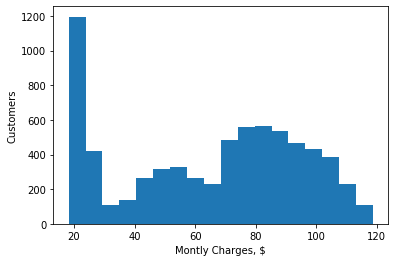

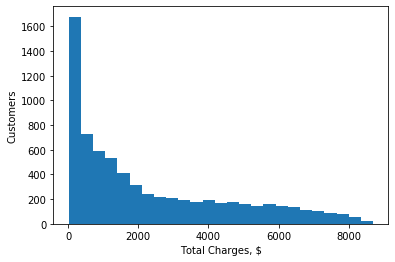

In [31]:
plt.hist(customers_data.MonthlyCharges, bins = "fd")
plt.xlabel("Montly Charges, $")
plt.ylabel("Customers")
plt.show()
plt.hist(customers_data.TotalCharges, bins = "fd")
plt.xlabel("Total Charges, $")
plt.ylabel("Customers")
plt.show()

Histogram for total charges is skewed right whereas for monthly charges is 3-modal. This is probably, because monthly charges include services that are monthly like HBO subscription, data bundles for internet traffic, free minutes bundles. Those services have exact prices. Whereas total charges is a sum of monthly charges plus everything that isn't included in his monthly services and it can be charges by minute, by MB, by sms or by watching a PPV sport game or movie. That's why histograms are different.

In [32]:
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
gender              7032 non-null object
SeniorCitizen       7032 non-null object
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null int64
tenure_months       7032 non-null object
dtypes: float64(2), int64(2), ob

In [33]:
customers_data.groupby("Churn")["MonthlyCharges"].describe().T

Churn,0,1
count,5163.000000,1869.000000
mean,61.307408,74.441332
std,31.094557,24.666053
min,18.250000,18.850000
25%,25.100000,56.150000
50%,64.450000,79.650000
75%,88.475000,94.200000
max,118.750000,118.350000


In [34]:
customers_data.groupby("Churn")["TotalCharges"].describe().T

Churn,0,1
count,5163.000000,1869.000000
mean,2555.344141,1531.796094
std,2329.456984,1890.822994
min,18.800000,18.850000
25%,577.825000,134.500000
50%,1683.600000,703.550000
75%,4264.125000,2331.300000
max,8672.450000,8684.800000


We see that churn customers pay more for MonthlyCharges then not churn customer based on mean values. On the other side, it's opposite for  TotalCharges. Mean for TotalCharges for not churn is 2555 $ while for churn is 1531 $. I'm not sure how to interpret this. May be churn customer use more services for which they pay more monthly but in the end their overall charges are less.

In [35]:
MonthlyCharges_Churn = customers_data[["MonthlyCharges", "Churn"]]
MonthlyCharges_Churn.head()

,MonthlyCharges,Churn
0,29.85,0
1,56.95,0
2,53.85,1
3,42.30,0
4,70.70,1


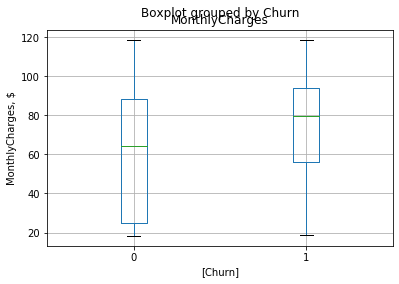

In [36]:
MonthlyCharges_Churn.boxplot(by = "Churn")
plt.ylabel("MonthlyCharges, $")
plt.show()

In [37]:
TotalCharges_Churn = customers_data[["TotalCharges", "Churn"]]
TotalCharges_Churn.head()

,TotalCharges,Churn
0,29.85,0
1,1889.50,0
2,108.15,1
3,1840.75,0
4,151.65,1


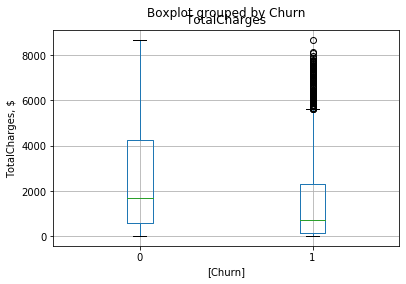

In [38]:
TotalCharges_Churn.boxplot(by = "Churn")
plt.ylabel("TotalCharges, $")
plt.show()

### 3. Data pre-processing

To get a got model I will scale variables tenure, MonthlyCharges and TotalCharges, preproces all categorical variables, prepare training and testing data.

In [39]:
customers_features_scaled = preprocessing.scale(customers_data[["tenure", "MonthlyCharges", "TotalCharges"]])
customers_features_scaled = pd.DataFrame(customers_features_scaled, columns=["tenure", "MonthlyCharges", "TotalCharges"])

C:\Users\DSPetrov\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [40]:
customers_features_scaled.shape

(7032, 3)

In [41]:
customers_data = pd.get_dummies(customers_data)

In [42]:
customers_data.shape

(7032, 46)

In [43]:
customers_data.update(customers_features_scaled)

In [44]:
customers_data.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_months_Months_0-12,tenure_months_Months_12-24,tenure_months_Months_24-36,tenure_months_Months_36-48,tenure_months_Months_48-60,tenure_months_Months_60-72
0,-1.280248,-1.161694,-0.994194,0,1,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,0
1,0.064303,-0.260878,-0.173740,0,0,1,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,-1.239504,-0.363923,-0.959649,1,0,1,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,0.512486,-0.747850,-0.195248,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,-1.239504,0.196178,-0.940457,1,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0


In [45]:
corr_all_data = customers_data.corr()
corr_all_data.style.background_gradient(cmap='coolwarm')

In [46]:
corr_all_data.Churn.sort_values(ascending = False)

Churn                                      1.000000
Contract_Month-to-month                    0.404565
tenure_months_Months_0-12                  0.319628
InternetService_Fiber optic                0.307463
PaymentMethod_Electronic check             0.301455
PaperlessBilling_Yes                       0.191454
OnlineSecurity_No                          0.171270
TechSupport_No                             0.164716
Dependents_No                              0.163128
SeniorCitizen_Yes                          0.150541
Partner_No                                 0.149982
OnlineBackup_No                            0.082307
DeviceProtection_No                        0.066193
StreamingTV_Yes                            0.063254
StreamingMovies_Yes                        0.060860
MultipleLines_Yes                          0.040033
tenure_months_Months_12-24                 0.019929
PhoneService_Yes                           0.011691
gender_Female                              0.008545
MonthlyCharg

We see that Contract_Month-to-month, tenure_months_Months_0-12, InternetService_Fiber optic, PaymentMethod_Electronic check  have strongest correlation to target variable Churn, but we shouldn't remove them, because correlation is not so strong. Interestingly the feature we created tenure_months_Months_0-12 have much stronger correlation to Churn then original numerical tenure feature. Hopefully this will help our model.

In [47]:
# split attributes and label data
customers_data_attributes = customers_data.drop("Churn", axis = 1)
customers_data_labels = customers_data.Churn

In [48]:
customers_data_attributes.shape

(7032, 45)

In [49]:
customers_data_labels.shape

(7032,)

In [50]:
# split data to train and test and for simplification let's use shorter names
X_train, X_test, y_train, y_test = train_test_split( \
        customers_data_attributes, customers_data_labels, train_size = 0.7, stratify = customers_data_labels)

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [51]:
X_train.shape

(4922, 45)

In [52]:
X_test.shape

(2110, 45)

In [53]:
y_train.shape

(4922,)

In [54]:
y_test.shape

(2110,)

### 4. Model Building

Our object is to predict Churn customer against not Churn customer. In order to evaluate our model we need to know few things.
1. Confusion matrix is table layout that allows visualization of the performance of an algorithm that shows predicted vs. actual classes.
    - true positive (TP) - model predicts customer churned and he actually churned
    - true negative (TN) - model predicts customer didn't churned and he actually didn't churned
    - false positive (FP) - model predicts customer churned when he actually didn't churned
    - false negative (FN) - model predicts customer didn't churned when he actually churned
    
     ![image](data/confusion_matrix.png)

2. Metrics
    - Accuracy = $ \frac {TP + TN} {TP + TN + FP + FN} $
    - Recall  = $ \frac {TP} {TP + FN} $
    - Precision = $ \frac {TP} {TP + FP} $
    - F1_score = $ \frac {2 \cdot Recall \cdot Precision} {Recall + Precision} $
    
Accuracy assumes equal costs for both kinds of errors, but since we have unbalance data, this metric is bad. Recall and precision give us different information for FN and FP results. We will use f1_score in order to balance both metrics and have in mind the unbalance data.
3. Receiver Operating Characteristic and Area Under the Curve: AUC - ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. You can find a great article here [ROC/AUC](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

In [55]:
k_fold = StratifiedKFold(n_splits = 5)

In order to evaluate our models while training and do a proper hyper-parameters tuning we have 2 options:
to use validation set or use cross-validation. Our train sample has only 4922 observation so if we use validation set, training set will get even smaller. In that case will be better to use cross-validation. We will use 5 folds for CV and to have a correct CV, we need to make each of the 5 folds to have same distribution of target variable Churn as in whole dataset. This mean to use StratifiedKFold function. We will use a few functions for operations we will make multiple times.

In [56]:
def model_performace(grid, X, y):
    print(f"GridSearchCV best parameters are: {grid.best_params_}")
    print(f"f1 scores for all our 5 folds during CV with k_fold are: \n \
                {cross_val_score(grid.best_estimator_, X_train, y_train, cv = k_fold, scoring= make_scorer(f1_score))}")
    print(classification_report(y, grid.best_estimator_.predict(X)))
    y_pred = grid.best_estimator_.predict(X)
    cm_data = pd.DataFrame({'Predicted': y_pred,'Actual': y},columns=['Actual','Predicted'])
    confusion_matrix = pd.crosstab(cm_data['Actual'], cm_data['Predicted'], rownames=['Actual'], colnames=['Predicted'])
    print(f'Confusion Matrix:\n {confusion_matrix}\n') 

model_performace() function shows us best parameters that GridSearchCV has chosen, based on scoring we have given to it and the hyper-parameters which GridSearchCV iterated on. Also we print classification report with accuracy, precision, recall and f1_score for each of the 2 values of target variable Churn. And in the end we print confusion matrix .

In [57]:
def plot_validation_curve_log(X, y, estimator, param_range, param_name, cv, title):
    
    train_scores, val_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=k_fold, scoring=make_scorer(f1_score))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("f1_score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, val_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    

In [58]:
def plot_validation_curve_normal(X, y, estimator, param_range, param_name, cv, title):
    
    train_scores, val_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=k_fold, scoring=make_scorer(f1_score))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("f1_score")
    plt.ylim(0.4, 0.8)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, val_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

We will use validation curve to compare how 1 hyper-parameter changes our target score for prediction.

In [59]:
def plot_learning_curve(grid, title, X, y, cv, train_sizes=np.linspace(.1, 1.0, 20)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("F1_score")
    train_sizes, train_scores, test_scores = learning_curve(grid.best_estimator_, X, y, cv=cv, train_sizes=train_sizes, scoring= make_scorer(f1_score))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.legend(loc="best")
    print(f"Variance = {(train_scores_mean[19] - test_scores_mean[19]) * 100}%")
    return plt

We will use learning curve to detect if our model has too much variance or bias. We calculate 20 points using training data and model that GridSearchCV choose and plot them. Then we plot 20 more point using CV. And we compare the 2 curves. 

In [60]:
def grid_save(file_name, grid_search):
    
    filename = "pickle_models/" + file_name
    outfile = open(filename,'wb')
    pickle.dump(grid_search,outfile)
    outfile.close()

We will use grid_save() function to save GridSearchCV model in files using pickle.

In [61]:
def grid_read(file_name):
    
    infile = open("pickle_models/" + file_name,'rb')
    grid_search = pickle.load(infile)
    infile.close()
    return grid_search

We will use grid_read() function to read GridSearchCV model from pickle saved file.

## 4.1. LogisticRegression

#### Let's start with one of more simple algorithms as logistic regression. Parameters we will try to tune with GridSearchCV are:
- C - C is regularization parameter. The bigger is C the less we care about the data(weak regularization)

In [62]:
if PICKLE:
    hyper_params = [{"C": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5], 
                     "max_iter": [10, 50, 100, 300, 1000],
                     "fit_intercept": [True, False]
                    }]

    grid_search_log_reg = GridSearchCV(estimator=LogisticRegression(), param_grid=hyper_params, cv = k_fold, scoring=make_scorer(f1_score))
    grid_search_log_reg.fit(X_train, y_train)
    
    grid_save("log_reg", grid_search_log_reg)
    
else:
    grid_search_log_reg = grid_read("log_reg")

In [63]:
model_performace(grid_search_log_reg, X_train, y_train)

GridSearchCV best parameters are: {'C': 10.0, 'fit_intercept': True, 'max_iter': 10}


C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.57569296 0.6        0.62978723 0.58773784 0.54663774]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3614
           1       0.68      0.53      0.59      1308

   micro avg       0.81      0.81      0.81      4922
   macro avg       0.76      0.72      0.73      4922
weighted avg       0.80      0.81      0.80      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3283  331
1           615  693



C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Variance = 0.8870010946307239%


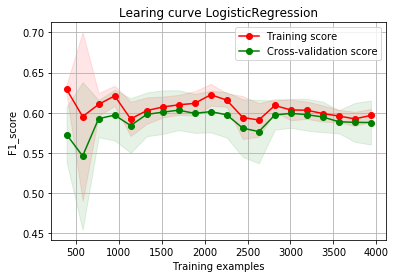

In [64]:
title = "Learing curve LogisticRegression"
plot_learning_curve(grid_search_log_reg, title, X_train, y_train, cv=k_fold)
plt.show()

We see that GridSearchCV found C=10 to be the best. Variance on validation set is 0.88 % which is very low. This means that we have very high bias. Also we see 2 curves almost follow each other which is not normal. We can try weaker regularization for our model by increasing C

In [65]:
if PICKLE:
    hyper_params = [{"C": [1e5, 1e6, 1e7, 1e9, 1e12], 
                     "max_iter": [10, 50, 100],
                     "fit_intercept": [True, False]
                    }]

    grid_search_log_reg_2 = GridSearchCV(estimator=LogisticRegression(), param_grid=hyper_params, cv = k_fold, scoring=make_scorer(f1_score))
    grid_search_log_reg_2.fit(X_train, y_train)
    
    grid_save("log_reg_2", grid_search_log_reg_2)
    
else:
    grid_search_log_reg_2 = grid_read("log_reg_2")

In [66]:
model_performace(grid_search_log_reg_2, X_train, y_train)

GridSearchCV best parameters are: {'C': 100000.0, 'fit_intercept': True, 'max_iter': 10}
f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.57569296 0.6        0.62978723 0.58773784 0.54663774]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3614
           1       0.68      0.53      0.59      1308

   micro avg       0.81      0.81      0.81      4922
   macro avg       0.76      0.72      0.73      4922
weighted avg       0.80      0.81      0.80      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3283  331
1           615  693



C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

Variance = 0.9024919079397509%


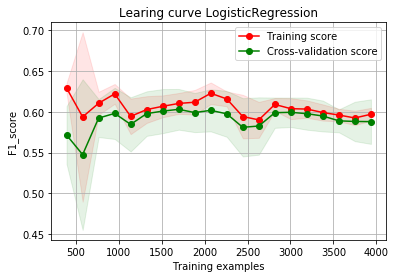

In [67]:
title = "Learing curve LogisticRegression"
plot_learning_curve(grid_search_log_reg_2, title, X_train, y_train, cv=k_fold)
plt.show()

We see that variance didn't change much after we increased "C" 10000 times. Also f1_score of 59% didn't change. On the validation curve below we can see that in fact our f1_score won't change for C > 1. Below that value, f1_score drops. Obviously we can't increase our predictions with that algorithm. 

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is i

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

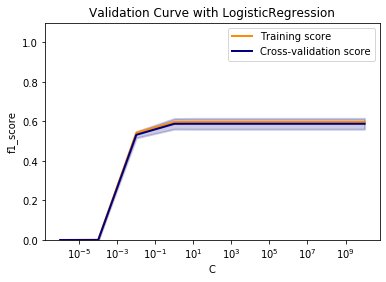

In [68]:
param_range = [1e-6, 1e-4, 1e-2, 1, 1e1, 1e2, 1e4, 1e6, 1e8, 1e10]
plot_validation_curve_log(X_train, y_train, estimator = LogisticRegression(), param_range = param_range, param_name = "C", 
                      cv = k_fold, title = "Validation Curve with LogisticRegression")

In [69]:
best_log_reg_estimator = grid_search_log_reg

### 4.2. Decission Tree

Let's try to make new model with DecisionTreeClassifier. Considering we have a lot categorical variables in our feature, may be this algorithm can produce better results. We have more hyper parameters which we can optimize with GridSearch this time. Those hyper parameters are:
- max_depth - This indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data
- min_samples_leaf - minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs, the base of the tree.
- max_leaf_nodes - Total number of terminal nodes (leaves) in a tree
- min_samples_split - represents the minimum number of samples required to split an internal node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node

In [70]:
if PICKLE:
    hyper_params = [{"max_depth": [10, 50, 100], 
                     "min_samples_leaf": [5, 25, 100],
                     "max_leaf_nodes": [5, 10, 50, 100],
                     "min_samples_split": [5, 10, 30, 50]}]

    grid_search_tree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_tree.fit(X_train, y_train)
    
    grid_save("decision_tree", grid_search_tree)

else:
    grid_search_tree = grid_read("decision_tree")

In [71]:
model_performace(grid_search_tree, X_train, y_train)

GridSearchCV best parameters are: {'max_depth': 10, 'max_leaf_nodes': 50, 'min_samples_leaf': 5, 'min_samples_split': 10}
f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.53941909 0.58248473 0.63909774 0.56626506 0.54863813]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3614
           1       0.69      0.61      0.65      1308

   micro avg       0.82      0.82      0.82      4922
   macro avg       0.78      0.75      0.76      4922
weighted avg       0.82      0.82      0.82      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3261  353
1           516  792



Variance = 8.902084139034205%


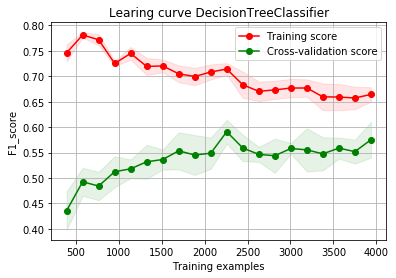

In [72]:
title = "Learing curve DecisionTreeClassifier"
plot_learning_curve(grid_search_tree, title, X_train, y_train, cv=k_fold)
plt.show()

We achieved better f1_score from LogisticRegression of 65% for Churn class but variance in CV is 8.9%. Let's try to overfit the model so then we can back up a little by put bias in with. hyper-parameters.

In [73]:
if PICKLE:
    hyper_params = [{"max_depth": [100, 200], 
                     "min_samples_leaf": [5, 10],
                     "max_leaf_nodes": [500],
                     "min_samples_split": [3, 5]}]
    
    grid_search_tree_2 = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_tree_2.fit(X_train, y_train)
    
    grid_save("decision_tree_2", grid_search_tree_2)

else:
    grid_search_tree_2 = grid_read("decision_tree_2")

In [74]:
model_performace(grid_search_tree_2, X_train, y_train)

GridSearchCV best parameters are: {'max_depth': 200, 'max_leaf_nodes': 500, 'min_samples_leaf': 10, 'min_samples_split': 3}
f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.46025105 0.54620123 0.53112033 0.50517598 0.47034765]
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      3614
           1       0.75      0.68      0.71      1308

   micro avg       0.85      0.85      0.85      4922
   macro avg       0.82      0.80      0.81      4922
weighted avg       0.85      0.85      0.85      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3315  299
1           421  887



Variance = 18.367193119407645%


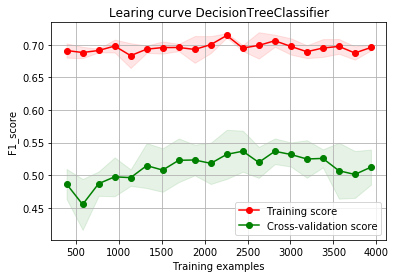

In [75]:
title = "Learing curve DecisionTreeClassifier"
plot_learning_curve(grid_search_tree_2, title, X_train, y_train, cv=k_fold)
plt.show()

We overfit the data as we wanted. It's obvious with 18.5% variance and the learning curve above.

Validation curve can help us test 1 hyper-parameter and see how f1_score will change.

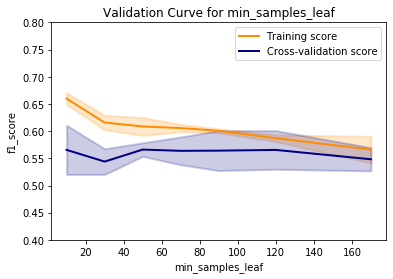

In [76]:
param_range = [10, 30, 50, 70, 90, 120,170]
plot_validation_curve_normal(X_train, y_train, estimator = grid_search_tree.best_estimator_, param_range = param_range, 
                      param_name = "min_samples_leaf", cv = k_fold, title = "Validation Curve for min_samples_leaf")

We will set min_samples_leaf around 50 in GridSearchCV to look around it for best score.

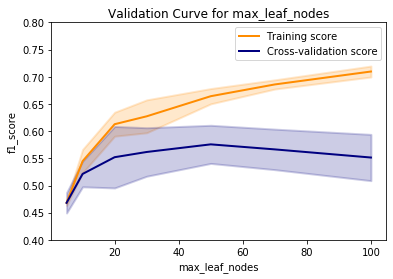

In [77]:
param_range = [5, 10, 20, 30, 50, 70, 100]

plot_validation_curve_normal(X_train, y_train, estimator = grid_search_tree.best_estimator_, param_range = param_range, 
                      param_name = "max_leaf_nodes", cv = k_fold, title = "Validation Curve for max_leaf_nodes")

max_leaf_nodes above 20 leads to big variance. Let's keep it around 20 and below.

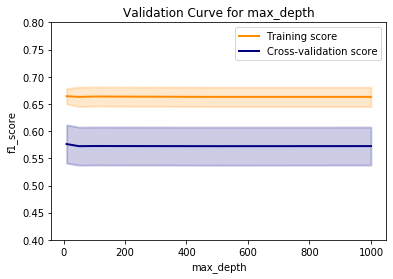

In [78]:
param_range = [10, 50, 100, 500, 1000]

plot_validation_curve_normal(X_train, y_train, estimator = grid_search_tree.best_estimator_, param_range = param_range, 
                      param_name = "max_depth", cv = k_fold, title = "Validation Curve for max_depth")

Curve above lies a little because max_depth is very important but with other static parameters curve don't change. But that doesn't mean that max_depth is unimportant parameter. 

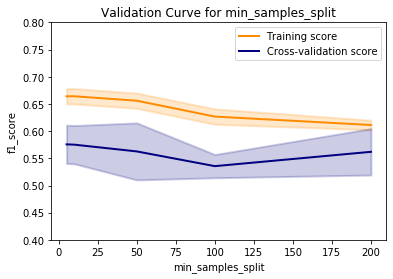

In [79]:
param_range = [5, 10, 50, 100, 200]

plot_validation_curve_normal(X_train, y_train, estimator = grid_search_tree.best_estimator_, param_range = param_range, 
                      param_name = "min_samples_split", cv = k_fold, title = "Validation Curve for min_samples_split")

So from 2 models so far we learned that 71% f1_score for Churn class is too much, because we overfit the data and when we run our test data in the model we will get very bad result, because our model has learned train data too good. From validation curves we see that optimal f1_score is around 60 to 65% at most. Let's try to make our tree smaller for next model so ig generalizes more our data.

In [80]:
if PICKLE:
    hyper_params = [{"max_depth": [20, 40, 70, 100], 
                     "min_samples_leaf": [10, 20, 30, 40],
                     "max_leaf_nodes": [10, 20, 30, 40],
                     "min_samples_split": [20, 40, 60]}]

    grid_search_tree_3 = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_tree_3.fit(X_train, y_train)
    
    grid_save("decision_tree_3", grid_search_tree_3)

else:
    grid_search_tree_3 = grid_read("decision_tree_3")

In [81]:
model_performace(grid_search_tree_3, X_train, y_train)

GridSearchCV best parameters are: {'max_depth': 70, 'max_leaf_nodes': 40, 'min_samples_leaf': 10, 'min_samples_split': 20}
f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.51835853 0.59302326 0.63377609 0.55935614 0.54403131]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3614
           1       0.68      0.59      0.63      1308

   micro avg       0.82      0.82      0.82      4922
   macro avg       0.77      0.75      0.76      4922
weighted avg       0.81      0.82      0.81      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3245  369
1           533  775



Variance = 8.338228228404265%


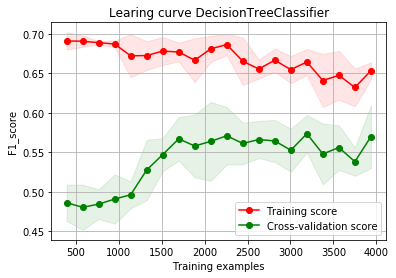

In [82]:
title = "Learing curve DecisionTreeClassifier"
plot_learning_curve(grid_search_tree_3, title, X_train, y_train, cv=k_fold)
plt.show()

Well we got moderate result of 63% for f1_score and variance of 8.3%. Can't be sure 1st or 3rd model is better. I will choose 1st, because his learning curve looks smoother then in 3rd model and there isn't big difference in their variance.

In [83]:
best_tree_estimator = grid_search_tree

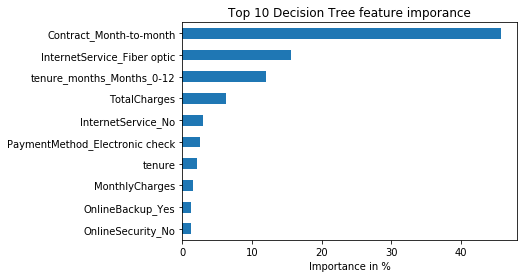

In [84]:
pd.Series(best_tree_estimator.best_estimator_.feature_importances_ * 100, index=customers_data_attributes.columns).nlargest(10).sort_values().plot(kind='barh')
plt.xlabel("Importance in %")
plt.title("Top 10 Decision Tree feature imporance")
plt.show()

We can see from models feature_importances_ the most important feature for him. They are: month-to-month contract, type of internet service and of course tenure. That's not surprising, because we saw most of them in our correlation matrix in our analysis earlier. 

In [85]:
dot_data = tree.export_graphviz(best_tree_estimator.best_estimator_, out_file=None,
                               feature_names = customers_data_attributes.columns,
                               class_names = ["Not churn","Churn"])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("data/tree_graph.pdf")

True

One of the best features of Decission trees is that you can visualise them. Below you can see the tree graph.

In [86]:
IFrame("data/tree_graph.pdf", width=900, height=600)

Let's move to ensembles algorithms.

### 4.3. Random forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement. Hyper-parameters we can tune are the same with addition of n_estimators which is the number of  DecisionTrees that RandomForestClassifier has. Let's try default RandomForestClassifier first.

In [87]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
print(classification_report(y_train, random_forest.predict(X_train)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3614
           1       0.99      0.95      0.97      1308

   micro avg       0.99      0.99      0.99      4922
   macro avg       0.99      0.98      0.98      4922
weighted avg       0.99      0.99      0.99      4922



It's easy to say we overfit the data right. Time for some tuning. First let's try giving our trees maximum of 2 questions to ask, but give our forest a lot of those trees.

In [89]:
if PICKLE:
    hyper_params = [{'n_estimators': [500, 1000, 2000],
                     'max_depth':[2]
                    }]

    grid_search_forest = GridSearchCV(estimator = RandomForestClassifier(), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_forest.fit(X_train, y_train)
    
    grid_save("random_forest", grid_search_forest)
    
else:
    grid_search_forest = grid_read("random_forest")

In [90]:
model_performace(grid_search_forest, X_train, y_train)

GridSearchCV best parameters are: {'max_depth': 2, 'n_estimators': 500}


C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:

f1 scores for all our 5 folds during CV with k_fold are: 
                 [0. 0. 0. 0. 0.]


C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.73      1.00      0.85      3614
           1       0.00      0.00      0.00      1308

   micro avg       0.73      0.73      0.73      4922
   macro avg       0.37      0.50      0.42      4922
weighted avg       0.54      0.73      0.62      4922

Confusion Matrix:
 Predicted     0
Actual         
0          3614
1          1308



C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:

Variance = 0.0%


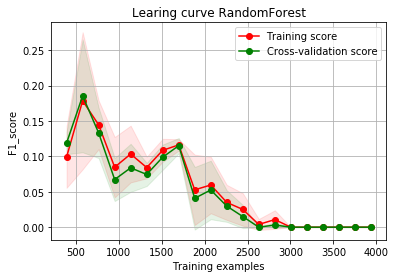

In [91]:
title = "Learing curve RandomForest"
plot_learning_curve(grid_search_forest, title, X_train, y_train, cv=k_fold)
plt.show()

Well this didn't go as well as we expected. Our model is garbage for Churn class. Let's give our GridSearchCV more parameters to work with.

It's clearly visible from learning curve that our model overfits the training data, because variance between training data and CV is 22.3 %. Too bad because 74% f1_score for Churn customers looked pretty good. We need to regularize our model. Let's lower number of trees(n_estimators) and max_depth and let's try higher value for min_samples_split and let's see what parameters GridSearchCV will choose.

In [92]:
if PICKLE:
    hyper_params = [{'n_estimators': [10, 50, 100, 200],
                     'min_samples_split': [10, 20, 30, 40, 50],
                     'max_depth':[5, 10, 50, 100]
                    }]

    grid_search_forest_2 = GridSearchCV(estimator = RandomForestClassifier(), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_forest_2.fit(X_train, y_train)
    
    grid_save("random_forest_2", grid_search_forest_2)
    
else:
    grid_search_forest_2 = grid_read("random_forest_2")

In [93]:
model_performace(grid_search_forest_2, X_train, y_train)

GridSearchCV best parameters are: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 10}
f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.55652174 0.5664488  0.54382022 0.50854701 0.49561404]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3614
           1       0.78      0.60      0.68      1308

   micro avg       0.85      0.85      0.85      4922
   macro avg       0.82      0.77      0.79      4922
weighted avg       0.84      0.85      0.84      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3398  216
1           529  779



Variance = 14.406028594940546%


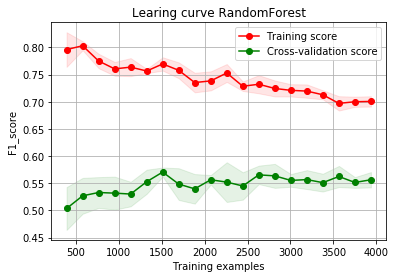

In [94]:
title = "Learing curve RandomForest"
plot_learning_curve(grid_search_forest_2, title, X_train, y_train, cv=k_fold)
plt.show()

We overfit the data again with so much variance of 15%. We need to prune  our trees a little by putting bias in our model and this will lower the variance. We see GridSearchCV best parameters are: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 10} for our last model. this means we have 10 trees with maximum 10 questions for each tree and min_samples_split is 10. Let's allow more trees with less questions.

In [95]:
if PICKLE:
    hyper_params = [{'n_estimators': [20, 50, 100, 200],
                     'min_samples_split': [5, 10, 20],
                     'max_depth':[3, 5, 8]
                    }]

    grid_search_forest_3 = GridSearchCV(estimator = RandomForestClassifier(), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_forest_3.fit(X_train, y_train)
    
    grid_save("random_forest_3", grid_search_forest_3)
else:
    grid_search_forest_3 = grid_read("random_forest_3")

In [96]:
model_performace(grid_search_forest_3, X_train, y_train)

GridSearchCV best parameters are: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 20}
f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.55328798 0.56306306 0.55504587 0.56155508 0.54625551]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      3614
           1       0.75      0.54      0.63      1308

   micro avg       0.83      0.83      0.83      4922
   macro avg       0.80      0.74      0.76      4922
weighted avg       0.82      0.83      0.82      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3376  238
1           603  705



Variance = 10.398168493295557%


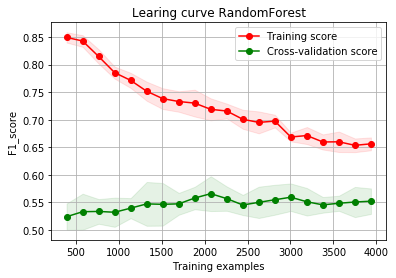

In [97]:
title = "Learing curve RandomForest"
plot_learning_curve(grid_search_forest_3, title, X_train, y_train, cv=k_fold)
plt.show()

I think we have a winner. Variance is 10% which is not small be I think we can live with it. F1_score of 63% less then f1_score for DecisionTreeClassifier but hopefully our forest will generalize better our data. We will see at the end with testing data.

In [98]:
best_forest_estimator = grid_search_forest_3

In [99]:
for name, importance in sorted(zip(best_forest_estimator.best_estimator_.feature_importances_,X_train.columns),reverse= True)[:5]:
    print(name, importance)

0.11719413506232512 tenure_months_Months_0-12
0.10304029087781616 InternetService_Fiber optic
0.09489577248547673 Contract_Month-to-month
0.06044359297377301 PaymentMethod_Electronic check
0.05846935131258725 Contract_Two year


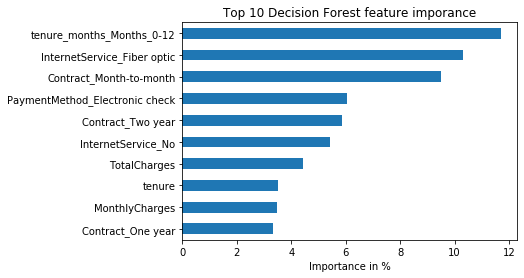

In [100]:
pd.Series(best_forest_estimator.best_estimator_.feature_importances_ * 100, index=customers_data_attributes.columns).nlargest(10).sort_values().plot(kind='barh')
plt.xlabel("Importance in %")
plt.title("Top 10 Decision Forest feature imporance")
plt.show()

Finally we see 10 most important features for our RandomForest. If you compare it with top feature is DecisionTreeClassifier you can see that here we have more evenly distributed percents for our top 10 features which should be good.

### 4.4. AdaBoost classifier

When nothing works, Boosting does. AdaBoost is one of the first boosting algorithms to be adapted in solving practices. How AdaBoost works?
1. Assign every observation $ x_i $, an initial weight value, $ w_i = \frac {1} {n} $, where n is the total number of observations.
2. Train a **weak** model. Most often decision tree, like we will do.
3. For each observation: 
    - If predicted incorrectly, $ w_i $ is increased
    - If predicted correctly, $ w_i $ is decreased
4. Train a new **weak** model where observations with greater weights are give more priority.
5. Repeat steps 3 and 4 until observations perfectly predicted or a present number of trees are trained.
Hyper-parameters we can tune are:
- n_estimators - number of models to iteratively train.
- learning_rate - contribution of each model to the weights.  Reducing the learning rate will mean the weights will be increased or decreased to a small degree, forcing the model train slower (but sometimes resulting in better performance scores).

For a start let's try DecisionTreeClassifier with max_depth=1.

In [101]:
if PICKLE:
    hyper_params = [{'n_estimators': [200, 500, 1000, 2000],
                     'learning_rate': [0.1, 0.2, 0.3]
                    }]

    grid_search_ada = GridSearchCV(estimator = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=1)), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_ada.fit(X_train, y_train)
    
    grid_save("ada_boost", grid_search_ada)

else:
    grid_search_ada = grid_read("ada_boost")

In [102]:
model_performace(grid_search_ada, X_train, y_train)

GridSearchCV best parameters are: {'learning_rate': 0.1, 'n_estimators': 1000}
f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.58297872 0.59388646 0.63731656 0.55882353 0.54468085]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      3614
           1       0.69      0.54      0.60      1308

   micro avg       0.81      0.81      0.81      4922
   macro avg       0.77      0.72      0.74      4922
weighted avg       0.80      0.81      0.80      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3290  324
1           603  705



Variance = 1.763251961689527%


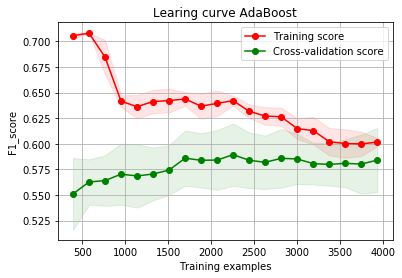

In [103]:
title = "Learing curve AdaBoost"
plot_learning_curve(grid_search_ada, title, X_train, y_train, cv=k_fold)
plt.show()

With variance of 1.76 % and the maximum 1000 trees in our GridSearchCV this model looks good. Let's try less trees but with max_depth=2 for each tree to compare results.

In [104]:
if PICKLE:
    hyper_params = [{'n_estimators': [100, 200, 300, 400, 500],
                     'learning_rate': [0.1, 0.2, 0.3]
                    }]

    grid_search_ada_2 = GridSearchCV(estimator = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=2)), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_ada_2.fit(X_train, y_train)
    
    grid_save("ada_boost_2", grid_search_ada_2)

else:
    grid_search_ada_2 = grid_read("ada_boost_2")

In [105]:
model_performace(grid_search_ada_2, X_train, y_train)

GridSearchCV best parameters are: {'learning_rate': 0.3, 'n_estimators': 100}
f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.56410256 0.59148936 0.60085837 0.53830228 0.54315789]
              precision    recall  f1-score   support

           0       0.86      0.92      0.88      3614
           1       0.71      0.57      0.63      1308

   micro avg       0.82      0.82      0.82      4922
   macro avg       0.78      0.74      0.76      4922
weighted avg       0.82      0.82      0.82      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3308  306
1           560  748



Variance = 7.8982145748110355%


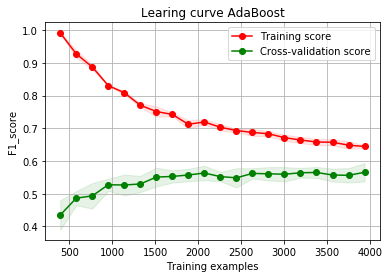

In [106]:
title = "Learing curve AdaBoost"
plot_learning_curve(grid_search_ada_2, title, X_train, y_train, cv=k_fold)
plt.show()

Well second learning curve seems better despite variance of 7.9 %. In first model curve changes more rapidly while second is smoother.

In [107]:
if PICKLE:
    hyper_params = [{'n_estimators': [50, 75, 100],
                     'learning_rate': [0.001, 0.1, 0.2, 0.3]
                    }]

    grid_search_ada_3 = GridSearchCV(estimator = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=7)), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_ada_3.fit(X_train, y_train)
    
    grid_save("ada_boost_3", grid_search_ada_3)

else:
    grid_search_ada_3 = grid_read("ada_boost_3")

In [108]:
model_performace(grid_search_ada_3, X_train, y_train)

GridSearchCV best parameters are: {'learning_rate': 0.001, 'n_estimators': 50}
f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.48407643 0.57864078 0.59375    0.53639847 0.52023121]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3614
           1       0.74      0.59      0.66      1308

   micro avg       0.84      0.84      0.84      4922
   macro avg       0.80      0.76      0.77      4922
weighted avg       0.83      0.84      0.83      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3349  265
1           539  769



Variance = 15.897164541618059%


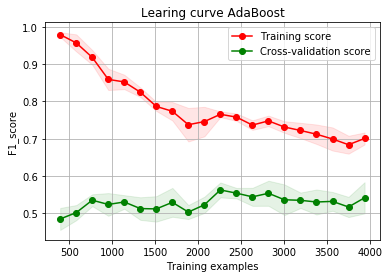

In [109]:
title = "Learing curve AdaBoost"
plot_learning_curve(grid_search_ada_3, title, X_train, y_train, cv=k_fold)
plt.show()

What we can say about 3 models we made? First model has small variance. I would say too small. Second model variance is 7.88 which is a lot but I think we can live with it. I tried for third model to give AdaBoost less but more deep trees to see if algorithm will overfit a lot or not so much. He overfit enough so it doesn't generalize the data enough so 3rd model is not good for us. We can pick second model.

In [110]:
best_ada_estimator = grid_search_ada_2

### 4.5.  SVC

Support Vectors Classifier tries to find the best hyperplane to separate the different classes by maximizing the distance between sample points and the hyperplane. Hyper-parameter we can tune:
- kernel - kernel parameters selects the type of hyperplane used to separate the data. We will try rbf and linear.
    - linear - uses linear will use a linear hyper-plane
    - rbf - uses a non linear hyper-plane
- gamma - parameter for non linear hyperplanes. Increasing gamma leads to overfitting as the classifier tries to perfectly fit the training data
- C - the penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly

In [111]:
if PICKLE:
    hyper_params = [{"C": [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4], 
                     "gamma": [0.001, 0.01, 0.1, 0.2, 0.5]
                    }]

    grid_search_svc = GridSearchCV(estimator = SVC(kernel = "rbf", probability = True), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_svc.fit(X_train, y_train)
    
    grid_save("svc", grid_search_svc)

else:
    grid_search_svc = grid_read("svc")

In [112]:
model_performace(grid_search_svc, X_train, y_train)

GridSearchCV best parameters are: {'C': 10000.0, 'gamma': 0.001}
f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.54623656 0.60042283 0.62447257 0.54273504 0.53017241]
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      3614
           1       0.72      0.53      0.61      1308

   micro avg       0.82      0.82      0.82      4922
   macro avg       0.78      0.73      0.75      4922
weighted avg       0.81      0.82      0.81      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3339  275
1           612  696



Variance = 5.92027976629722%


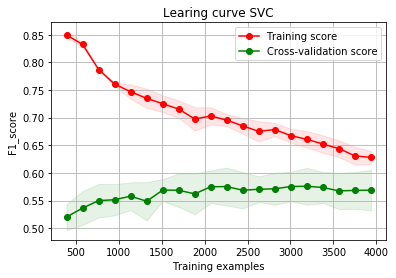

In [113]:
title = "Learing curve SVC"
plot_learning_curve(grid_search_svc, title, X_train, y_train, cv=k_fold)
plt.show()

In [114]:
if PICKLE:
    hyper_params = [{"C": [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]}]

    grid_search_svc_linear = GridSearchCV(estimator = LinearSVC(), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_svc_linear.fit(X_train, y_train)
    
    grid_save("svc_linear", grid_search_svc_linear)

else:
    grid_search_svc_linear = grid_read("svc_linear")

In [115]:
model_performace(grid_search_svc_linear, X_train, y_train)

GridSearchCV best parameters are: {'C': 10.0}


C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.59259259 0.58093126 0.61002179 0.61818182 0.55691057]
              precision    recall  f1-score   support

           0       0.84      0.92      0.87      3614
           1       0.69      0.50      0.58      1308

   micro avg       0.81      0.81      0.81      4922
   macro avg       0.76      0.71      0.73      4922
weighted avg       0.80      0.81      0.80      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3319  295
1           655  653



C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

Variance = 0.2256939935957547%


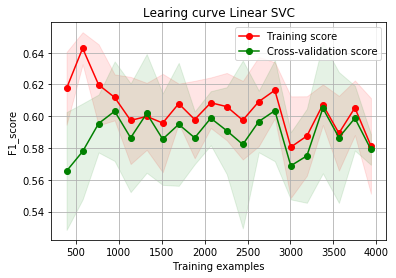

In [116]:
title = "Learing curve Linear SVC"
plot_learning_curve(grid_search_svc_linear, title, X_train, y_train, cv=k_fold)
plt.show()

Linear SVC couldn't converge so it underfit the data. So we need to increase number of iterations.

In [117]:
if PICKLE:
    hyper_params = [{"C": [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]}]

    grid_search_svc_linear_2 = GridSearchCV(estimator = LinearSVC(max_iter = 1e4), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_svc_linear_2.fit(X_train, y_train)
    
    grid_save("svc_linear_2", grid_search_svc_linear_2)

else:
    grid_search_svc_linear_2 = grid_read("svc_linear_2")

In [118]:
model_performace(grid_search_svc_linear_2, X_train, y_train)

GridSearchCV best parameters are: {'C': 100.0}


C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.53452116 0.61089494 0.60737527 0.54292343 0.56262834]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3614
           1       0.67      0.55      0.60      1308

   micro avg       0.81      0.81      0.81      4922
   macro avg       0.76      0.72      0.74      4922
weighted avg       0.80      0.81      0.80      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3256  358
1           591  717



C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

Variance = 1.1389255084622407%


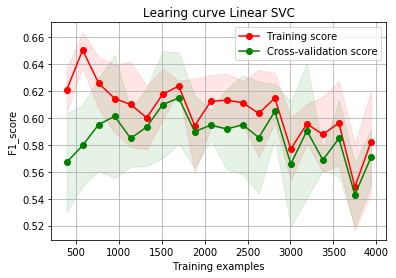

In [119]:
title = "Learing curve Linear SVC"
plot_learning_curve(grid_search_svc_linear_2, title, X_train, y_train, cv=k_fold)
plt.show()

Even win 10000 iteration we couldn't converge. Unfortunately algorithm is too slow and we don't have time to wait him by increasing max_iter parameter. We will take our Gaussian SVC model for final evaluation. He performed fairly good with 5.92% variance and f1_score of 61%.

In [120]:
best_svc_estimator = grid_search_svc

### 4.6. XGBoost

XGBoost is Gradient Boosting algorithm through parallel processing, tree-pruning, handling missing values and regularization to avoid overfitting/bias. Algorithm performs better and trains faster then most algorithms but he has a lot of hyper-parameters that can be tuned. We will use only those:
- max_depth  - maximum depth of a tree
- reg_lambda - L2 regularization term on weights
- learning_rate - learning rate
- n_estimators - number of models to iteratively train

In [121]:
if PICKLE:
    
    hyper_params = [{'max_depth': [3, 5, 7, 10],
                    'n_estimators': [50,100,150,300],
                    'learning_rate': [0.01, 0.1, 0.3],
                    'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100]
                    }]

    grid_search_xgboost = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic'), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_xgboost.fit(X_train,y_train)

    grid_save("xgboost", grid_search_xgboost)

else:
    grid_search_xgboost = grid_read("xgboost")

In [122]:
model_performace(grid_search_xgboost, X_train, y_train)

GridSearchCV best parameters are: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'reg_lambda': 100}
f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.56410256 0.5877193  0.6212766  0.56846473 0.55744681]
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      3614
           1       0.69      0.53      0.60      1308

   micro avg       0.81      0.81      0.81      4922
   macro avg       0.77      0.72      0.74      4922
weighted avg       0.80      0.81      0.80      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3298  316
1           609  699



Variance = 3.1577086163047663%


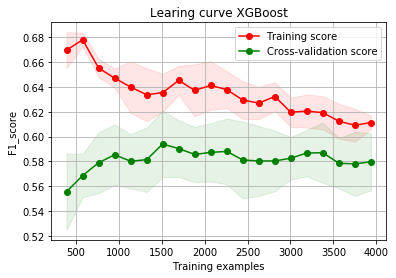

In [123]:
title = "Learing curve XGBoost"
plot_learning_curve(grid_search_xgboost, title, X_train, y_train, cv=k_fold)
plt.show()

This model underfits a little. Let's try to increase his variance by increasing max_depth and n_estimators, decrease reg_lambda.

In [124]:
if PICKLE:
    hyper_params = [{'max_depth': [5, 7, 10],
                    'n_estimators': [150, 200, 400],
                    'learning_rate': [0.01, 0.1, 0.3],
                    'reg_lambda': [1e-2, 0.1, 1]
                    }]

    grid_search_xgboost_2 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic'), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_xgboost_2.fit(X_train,y_train)
    
    grid_save("xgboost_2", grid_search_xgboost_2)

else:
    grid_search_xgboost_2 = grid_read("xgboost_2")

In [125]:
model_performace(grid_search_xgboost_2, X_train, y_train)

GridSearchCV best parameters are: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 150, 'reg_lambda': 0.01}
f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.55411255 0.58024691 0.59354839 0.56485356 0.50317125]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      3614
           1       0.79      0.64      0.71      1308

   micro avg       0.86      0.86      0.86      4922
   macro avg       0.83      0.79      0.81      4922
weighted avg       0.85      0.86      0.85      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3385  229
1           470  838



Variance = 15.954806906920604%


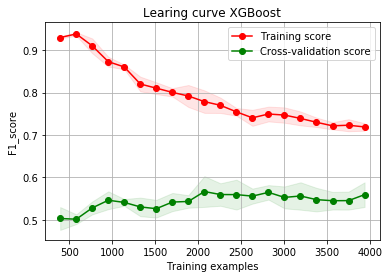

In [126]:
title = "Learing curve XGBoost"
plot_learning_curve(grid_search_xgboost_2, title, X_train, y_train, cv=k_fold)
plt.show()

We kind of overfit the data. Let's find the bull's eye with our 3rd model. Shell we?

In [127]:
if PICKLE:
    hyper_params = [{'max_depth': [3, 4, 5],
                    'n_estimators': [300, 500, 1000],
                    'learning_rate': [0.01, 0.1, 0.3],
                     'reg_lambda': [0, 0.1]
                    }]

    grid_search_xgboost_3 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic'), param_grid = hyper_params, scoring = make_scorer(f1_score), cv = k_fold)
    grid_search_xgboost_3.fit(X_train,y_train)
    
    grid_save("xgboost_3", grid_search_xgboost_3)

else:
    grid_search_xgboost_3 = grid_read("xgboost_3")

In [128]:
model_performace(grid_search_xgboost_3, X_train, y_train)

GridSearchCV best parameters are: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'reg_lambda': 0.1}
f1 scores for all our 5 folds during CV with k_fold are: 
                 [0.56223176 0.58951965 0.61571125 0.56603774 0.54506438]
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      3614
           1       0.71      0.56      0.63      1308

   micro avg       0.82      0.82      0.82      4922
   macro avg       0.78      0.74      0.76      4922
weighted avg       0.82      0.82      0.82      4922

Confusion Matrix:
 Predicted     0    1
Actual              
0          3315  299
1           571  737



Variance = 5.5025999230922995%


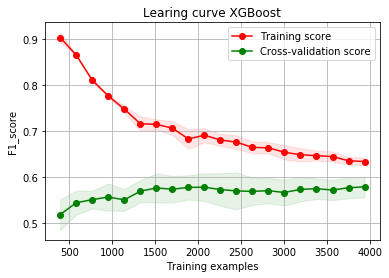

In [129]:
title = "Learing curve XGBoost"
plot_learning_curve(grid_search_xgboost_3, title, X_train, y_train, cv=k_fold)
plt.show()

We made 3 models with GridSearch. Difference between second and third is very slim. Variance is 10.4% vs 11.1 %, f1_score is 66% vs 65 %. Where as first model f1_score is 59% with variance of 2.06 %. I think there is too much bias in first model and learning curve isn't very smooth so after all I will choose second model for final evaluation.

In [130]:
best_xgb_estimator = grid_search_xgboost_3

### 5. Model Performances

We have 6 algorithms. We choose them after cross_validation and hyper-parameter tuning using GridSearchCV. We will use f1_score, ROC Curves, Precision-Recall Curves. Receiver Operating Characteristic curve is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis). It describes how good the model is at predicting the positive class when the actual outcome is positive. This plot is more appropriate when we have balance classes, which we don't have but we use it mainly for visualization. For optimal result in comparing we will use Precision-Recall Curve. We already know what precision and recall are. Key to the calculation of precision and recall is that the calculations do not make use of the true negatives. It is only concerned with the correct prediction of the minority class, class 1. The no-skill line is defined by the total number of positive cases divide by the total number of positive and negative cases. For a dataset with an equal number of positive and negative cases, this is a diagonal line from the top left (0,1) to the bottom right (1,0). Points above this line show skill.

In [131]:
models_for_evaluation = \
{"LogisticRegression": best_log_reg_estimator, 
 "DecisionTreeClassifier": best_tree_estimator,
 "RandomForestClassifier": best_forest_estimator,
 "AdaBoostClassifier": best_ada_estimator,
 "SVC": best_svc_estimator,
 "XGBClassifier": best_xgb_estimator
}

In [132]:
def model_performace_testing_data(grid, X, y):
    
    print(classification_report(y, grid.best_estimator_.predict(X)))
    y_pred = grid.predict(X)
    cm_data = pd.DataFrame({'Predicted': y_pred,'Actual': y},columns=['Actual','Predicted'])
    cm = pd.crosstab(cm_data['Actual'], cm_data['Predicted'], rownames=['Actual'], colnames=['Predicted'])
    print(f'Confusion Matrix:\n {cm}\n') 


In [133]:
for name, model in models_for_evaluation.items():
    print(f"{name} classification report:")
    model_performace_testing_data(model, X_test, y_test)

LogisticRegression classification report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1549
           1       0.63      0.50      0.56       561

   micro avg       0.79      0.79      0.79      2110
   macro avg       0.73      0.70      0.71      2110
weighted avg       0.78      0.79      0.78      2110

Confusion Matrix:
 Predicted     0    1
Actual              
0          1386  163
1           279  282

DecisionTreeClassifier classification report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1549
           1       0.57      0.51      0.54       561

   micro avg       0.77      0.77      0.77      2110
   macro avg       0.70      0.69      0.69      2110
weighted avg       0.76      0.77      0.76      2110

Confusion Matrix:
 Predicted     0    1
Actual              
0          1333  216
1           274  287

RandomForestClassifier classification report:
    

In [134]:
for name, model in models_for_evaluation.items():
    print(f"{name}: f1_score = {f1_score(y_test, model.predict(X_test)):.3f}")

LogisticRegression: f1_score = 0.561
DecisionTreeClassifier: f1_score = 0.539
RandomForestClassifier: f1_score = 0.528
AdaBoostClassifier: f1_score = 0.524
SVC: f1_score = 0.548
XGBClassifier: f1_score = 0.548


In [135]:
def plot_roc_curve(name, model):
    
    no_skill_probs = [0 for _ in range(len(y_test))]
    model_probs = model.predict_proba(X_test)
    model_probs = model_probs[:, 1]
    no_skill_auc = roc_auc_score(y_test, no_skill_probs)
    model_auc = roc_auc_score(y_test, model_probs)
    print(f"No Skill: ROC AUC={no_skill_auc:.3f}")
    print(f"{name}: ROC AUC={model_auc:.3f}")
    no_skill_fpr, no_skill_tpr, _ = roc_curve(y_test, no_skill_probs)
    model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)
    # plot the roc curve for the model
    plt.plot(no_skill_fpr, no_skill_tpr, linestyle='--', label='No Skill')
    plt.plot(model_fpr, model_tpr, marker='.', label=name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title(f"{name} ROC curve")
    plt.show()

No Skill: ROC AUC=0.500
LogisticRegression: ROC AUC=0.830


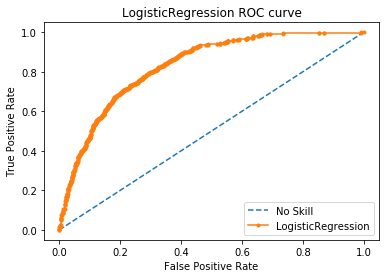

No Skill: ROC AUC=0.500
DecisionTreeClassifier: ROC AUC=0.802


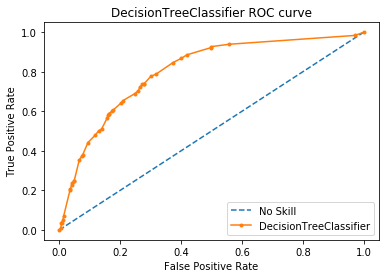

No Skill: ROC AUC=0.500
RandomForestClassifier: ROC AUC=0.823


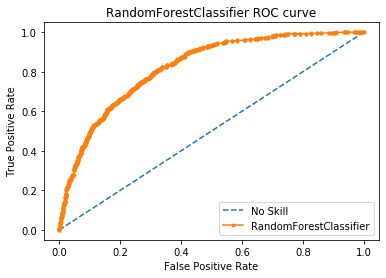

No Skill: ROC AUC=0.500
AdaBoostClassifier: ROC AUC=0.793


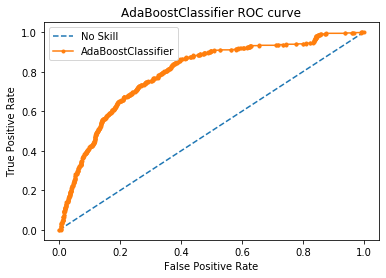

No Skill: ROC AUC=0.500
SVC: ROC AUC=0.804


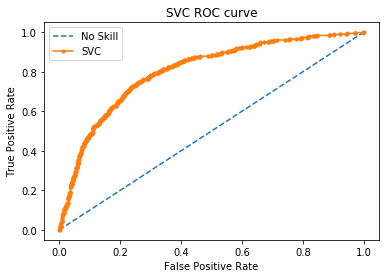

No Skill: ROC AUC=0.500
XGBClassifier: ROC AUC=0.829


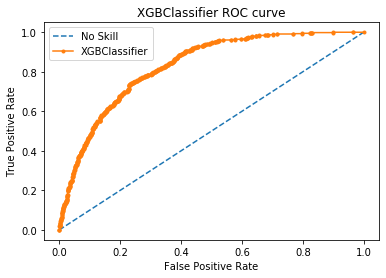

In [136]:
for name, model in models_for_evaluation.items(): 
    plot_roc_curve(name, model)


In [137]:
def plot_pr_curve(name, model):

    no_skill_probs = [0 for _ in range(len(y_test))]
    model_probs = model.predict_proba(X_test)
    model_probs = model_probs[:, 1]
    y_pred = model.predict(X_test)
    no_skill_precision, no_skill_recall, _ = precision_recall_curve(y_test, no_skill_probs)
    model_precision, model_recall, _ = precision_recall_curve(y_test, model_probs)
    no_skill_f1, no_skill_auc = f1_score(y_test, no_skill_probs), auc(no_skill_recall, no_skill_precision)
    model_f1, model_auc = f1_score(y_test, y_pred), auc(model_recall, model_precision)
    print(f'No Skill: f1={no_skill_f1:.3f} auc={no_skill_auc:.3f}')
    print(f'{name}: f1={model_f1:.3f} auc={model_auc:.3f}')
    plt.plot(no_skill_recall, no_skill_precision, linestyle='--', label='No Skill')
    plt.plot(model_recall, model_precision, marker='.', label=name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


No Skill: f1=0.000 auc=0.633
LogisticRegression: f1=0.561 auc=0.605


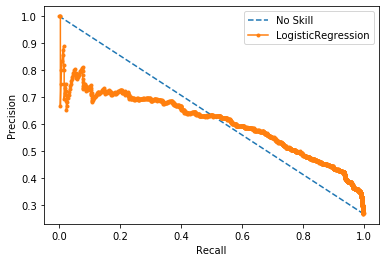

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


No Skill: f1=0.000 auc=0.633
DecisionTreeClassifier: f1=0.539 auc=0.557


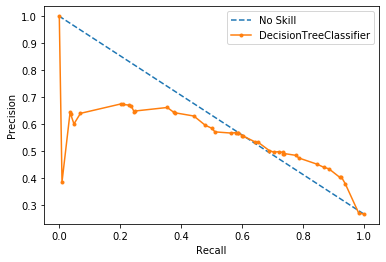

No Skill: f1=0.000 auc=0.633
RandomForestClassifier: f1=0.528 auc=0.606


C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


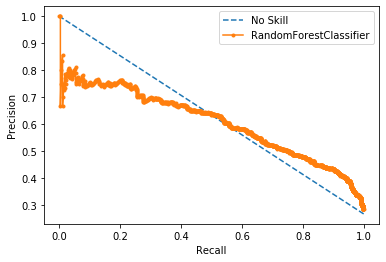

No Skill: f1=0.000 auc=0.633
AdaBoostClassifier: f1=0.524 auc=0.549


C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


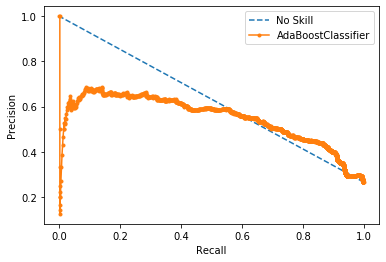

No Skill: f1=0.000 auc=0.633
SVC: f1=0.548 auc=0.573


C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


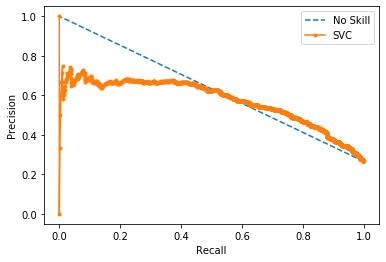

No Skill: f1=0.000 auc=0.633
XGBClassifier: f1=0.548 auc=0.605


C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


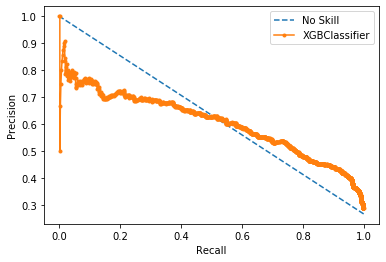

In [138]:
for name, model in models_for_evaluation.items():
    plot_pr_curve(name, model)

We have our results. All votes are counted and we have something unexpected. Winner of 6 models is LogisticRegression with f1_score = 0.561, ROC AUC=0.830 PRC AUC=0.605. Only in PRC AUC model lost by 0.001 from RandomForestClassifier. Surprisingly or not this is our results after we cleaned and scaled our data. Split the data in training and testing. We trained 6 models with cross-validation and hyper-parameter tuning. But after all this the most simple model turned out to be the best. When I looked at previous projects that are made on the dataset it turned out other people got best results again with LogisticRegression. Other important question: is f1_score = 0.561 a good result. It's not the best and I would say with this data it's fairly good result and model. How can we help our model to improve that result? We can try oversampling of minor class(1) with SMOTE for example. This can help us improve predictions a little. I don't think PCA is appropriate in our case considering we have 7000 observations with 46 numerical features. To take in perspective our result I will tell you what a colleague of mine told me. He works in telecom operator that I work. He is ML Architect for more then 15 years. A few years ago they were asked to make Churn prediction model the way we did it. He had data for 1.5 million customer which is great. No bad part is only about 1% of that 1.5 million were in fact churn customer. This is more likely anomaly detection. But on other had they had more then 250 feature. After all work engineers did, best model they trained managed to predict 36% of all churn customers. I know that's not metric we use but if we compare it with our model, we managed to predict 50.3% of all churn customer correctly. In the end financial department and marketing weren't happy with the model. They wanted a model to predict at least 90% of churn customer correctly. Otherwise it's not worth it for the company to give better deals to customer with are predicted to churn. Why with 1.5 million customers and 250 feature the model predicted so poorly, I asked my colleague. The reason is that every person who churn may have totally different reason to do so. For example, death, emigrating abroad or even changing city in a country. Customer even doesn't have to be disappointed with his operator. He may have never filed a single customer complain to his operator. Customer starts a new job and receives a new phone number. This can be a reason to churn. When we started this project we were thinking that we have simple classification problem with only 2 class. It shouldn't be hard to get results for f1 above 90%. First our data is imbalance, second we have only 7000 observations with. And for me the most important thing is that people are really hard to predict in this case. I suppose we could achieve better results if we keep fine tuning our models but even with the little parameters that I used for GridSearchCV models like SVC, AdaBoost and XGBoost needed 30 to 60 minutes to train. Also if we can get more data this can help our model but we can say it with 100% certainty. It was great experience working on the project. I hope it's the same for you reader.

### References:
https://towardsdatascience.com/ai-101-understanding-customer-customers_data-management-514416c17643

https://towardsdatascience.com/predict-customer-customers_data-with-r-9e62357d47b4

https://www.kaggle.com/pavanraj159/telecom-customer-customers_data-prediction

https://towardsdatascience.com/hands-on-predict-customer-customers_data-5c2a42806266

https://www.displayr.com/predict-customer-customers_data-gradient-boosting/

https://neilpatel.com/blog/improve-by-predicting-customers_data/

https://towardsdatascience.com/customers_data-prediction-770d6cb582a5

https://medium.com/into-advanced-procurement/predict-customer-customers_data-with-machine-learning-c3fdb58ba4e3

https://towardsdatascience.com/building-an-employee-customers_data-model-in-python-to-develop-a-strategic-retention-plan-57d5bd882c2d

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

SVM - https://www.csie.ntu.edu.tw/~r95162/guide.pdf

XGBoost - https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
